In [2]:
# Import the relevant libraries
import numpy as np
import pandas as pd
import datetime
import requests
import matplotlib.pyplot as plt

In [3]:
# Import the relevant libraries
import os
import json
import zipfile
import shutil
import random
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from shutil import copyfile

print(tf.__version__)

2.3.0


In [4]:
# Import the inception V3 model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Clear any exiting model
tf.keras.backend.clear_session()

pre_trained_model = InceptionV3(input_shape = (150,150,3), # reshape images to 150 by 150 by 3 channels
                                include_top = False, # get straight to the CNN layer
                                weights = 'imagenet') # use the builed-in weight pre-trained on imagent

# Make all the layers in the pre-trained model non-trainable/frozen
for layer in pre_trained_model.layers:
    layer.trainable = False

In [5]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

__________________________________________________________________________________________________
mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_60[0][0]              
                                                                 activation_63[0][0]              
                                                                 activation_68[0][0]              
                                                                 activation_69[0][0]              
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 7, 7, 192)    147456      mixed7[0][0]                     
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 7, 7, 192)    576         conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation

In [6]:
# Pick one layer from the middle of the model
# We well build new dense layers after this layer

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [7]:
# Define a Callback class that stops training once accuracy reaches a threshold

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.875):
            print("\nReached 87.5% accuracy so cancelling training!")
            self.model.stop_training = True

In [8]:
from tensorflow.keras.optimizers import RMSprop

# Add layers after the picked last_layer
# Note that the layers below are trainable. 
# On the other hand, the layers up to the last_output is fronzen and non-trainable.

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for binary classification
# x = layers.Dense(1, activation='sigmoid')(x)           
                  
# Add a final softmax layer for classification
x = layers.Dense(3, activation='softmax')(x)         

# instantiate a new model 
model = Model(pre_trained_model.input ,x) 

# Compile a model
model.compile(optimizer = RMSprop(lr=0.0001),  # We use RMSprop in this case
              loss = 'categorical_crossentropy',  # up, flat, or down
              metrics = ['acc']) # 'acc' stands for accuracy

# See the summary of the model 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

activation_67 (Activation)      (None, 7, 7, 192)    0           batch_normalization_67[0][0]     
__________________________________________________________________________________________________
average_pooling2d_6 (AveragePoo (None, 7, 7, 768)    0           mixed6[0][0]                     
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 7, 7, 192)    147456      mixed6[0][0]                     
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 7, 7, 192)    258048      activation_62[0][0]              
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 7, 7, 192)    258048      activation_67[0][0]              
__________________________________________________________________________________________________
conv2d_69 

Store the files 

One day ahead

In [9]:
#train_set and test_set
base_train_dir = './capstone_data/train_data_1/'
base_val_dir = './capstone_data/test_data_1/'

#up
train_up_fnames = os.listdir('./capstone_data/train_data_1/up_data')
print(train_up_fnames)

#flat
train_flat_fnames = os.listdir('./capstone_data/train_data_1/flat_data')
print(train_flat_fnames)

#down
train_down_fnames = os.listdir('./capstone_data/train_data_1/down_data')
print(train_down_fnames)

['up_mpf_candle_1993-02-16.png', 'up_mpf_candle_1993-02-22.png', 'up_mpf_candle_1993-02-26.png', 'up_mpf_candle_1993-03-10.png', 'up_mpf_candle_1993-03-17.png', 'up_mpf_candle_1993-04-01.png', 'up_mpf_candle_1993-04-19.png', 'up_mpf_candle_1993-04-23.png', 'up_mpf_candle_1993-05-11.png', 'up_mpf_candle_1993-05-18.png', 'up_mpf_candle_1993-05-21.png', 'up_mpf_candle_1993-06-16.png', 'up_mpf_candle_1993-06-18.png', 'up_mpf_candle_1993-06-29.png', 'up_mpf_candle_1993-07-16.png', 'up_mpf_candle_1993-07-21.png', 'up_mpf_candle_1993-07-30.png', 'up_mpf_candle_1993-08-06.png', 'up_mpf_candle_1993-08-10.png', 'up_mpf_candle_1993-08-16.png', 'up_mpf_candle_1993-09-01.png', 'up_mpf_candle_1993-09-14.png', 'up_mpf_candle_1993-09-15.png', 'up_mpf_candle_1993-09-17.png', 'up_mpf_candle_1993-10-06.png', 'up_mpf_candle_1993-10-07.png', 'up_mpf_candle_1993-10-20.png', 'up_mpf_candle_1993-11-02.png', 'up_mpf_candle_1993-11-15.png', 'up_mpf_candle_1993-12-03.png', 'up_mpf_candle_1993-12-09.png', 'up_mpf

Rescale the files and feed them into generator

In [21]:
# Rescale the training_data
train_datagen = ImageDataGenerator(rescale = 1.0/255.0) # rescale the images within 0-1. This yield better results when handling images. 

# Rescale the test data
test_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(base_train_dir,
                                                    batch_size = 10,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))     

# Flow validation images in batches of 10 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(base_val_dir,
                                                         batch_size = 10,
                                                         class_mode = 'categorical',
                                                         target_size = (150,150))

Found 5890 images belonging to 3 classes.
Found 1002 images belonging to 3 classes.


In [22]:
# See the indices of the classes
# In keras ImageDataGenerator class, classes are indexed in alphabetical order
train_generator.class_indices

{'down_data': 0, 'flat_data': 1, 'up_data': 2}

Training

For one day ahead

In [23]:
# Fit the model the training data
# Take the log of the training in history
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
                                                      
callbacks = myCallback()

history = model.fit_generator(
    generator = train_generator, # feed the training data via the generator
    steps_per_epoch = 8, # this is the batch size. parameters are updated per this batch size
    epochs = 100, # number of cycles. In one epoch, the whole dataset is used once.
    verbose = 2, # print out the logs
    callbacks = [callbacks],
    #callbacks=[tensorboard_callback], # use callbacks we set before
    validation_data = validation_generator, # feed the validation data via the generator
    validation_steps = 10 
)

Epoch 1/100
8/8 - 7s - loss: 2.8431 - acc: 0.3625 - val_loss: 1.1195 - val_acc: 0.4400
Epoch 2/100
8/8 - 6s - loss: 1.1546 - acc: 0.5250 - val_loss: 1.1465 - val_acc: 0.6000
Epoch 3/100
8/8 - 5s - loss: 1.3099 - acc: 0.3875 - val_loss: 1.2819 - val_acc: 0.2000
Epoch 4/100
8/8 - 5s - loss: 1.2552 - acc: 0.3750 - val_loss: 1.2829 - val_acc: 0.3000
Epoch 5/100
8/8 - 5s - loss: 1.3107 - acc: 0.3500 - val_loss: 1.0544 - val_acc: 0.4800
Epoch 6/100
8/8 - 5s - loss: 1.2166 - acc: 0.3625 - val_loss: 1.4296 - val_acc: 0.1800
Epoch 7/100
8/8 - 5s - loss: 1.4687 - acc: 0.2500 - val_loss: 1.3592 - val_acc: 0.1500
Epoch 8/100
8/8 - 5s - loss: 1.3061 - acc: 0.2625 - val_loss: 1.0233 - val_acc: 0.6200
Epoch 9/100
8/8 - 5s - loss: 1.3018 - acc: 0.2375 - val_loss: 1.0034 - val_acc: 0.4900
Epoch 10/100
8/8 - 4s - loss: 1.0386 - acc: 0.5000 - val_loss: 1.0006 - val_acc: 0.5700
Epoch 11/100
8/8 - 4s - loss: 1.0520 - acc: 0.5375 - val_loss: 0.8864 - val_acc: 0.6500
Epoch 12/100
8/8 - 4s - loss: 1.1667 - ac

Epoch 95/100
8/8 - 3s - loss: 1.0415 - acc: 0.5000 - val_loss: 1.1372 - val_acc: 0.3700
Epoch 96/100
8/8 - 3s - loss: 1.0185 - acc: 0.4750 - val_loss: 0.9987 - val_acc: 0.5500
Epoch 97/100
8/8 - 3s - loss: 1.0833 - acc: 0.4625 - val_loss: 0.9174 - val_acc: 0.6200
Epoch 98/100
8/8 - 3s - loss: 0.9603 - acc: 0.5625 - val_loss: 0.9220 - val_acc: 0.6300
Epoch 99/100
8/8 - 3s - loss: 0.9756 - acc: 0.5125 - val_loss: 0.9829 - val_acc: 0.5900
Epoch 100/100
8/8 - 3s - loss: 1.0799 - acc: 0.4500 - val_loss: 1.0823 - val_acc: 0.3900


Results for the one day ahead forcast

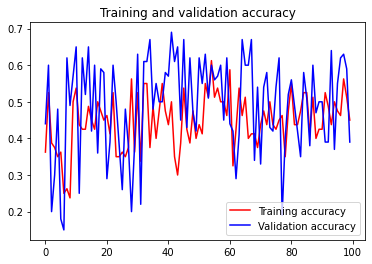

<Figure size 432x288 with 0 Axes>

In [24]:
# One day ahead
# Plot the accuracy history 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

How can it be this bad?



<hr>

In [27]:
print("Evaluate")
result = model.evaluate(train_generator)
dict(zip(model.metrics_names, result))

Evaluate
589/589 [==============================] - 92s 156ms/step - loss: 1.0173 - acc: 0.5034


{'loss': 1.0173472166061401, 'acc': 0.5033955574035645}

Results for the three days ahead forecast

In [ ]:
print("Evaluate")
result2 = model.evaluate(validation_generator)
dict(zip(model.metrics_names, result2))

Evaluate
 68/101 [===================>..........] - ETA: 4s - loss: 1.0827 - acc: 0.4176